# Individual_Assignment_Retail
<img src="https://d26a57ydsghvgx.cloudfront.net/product/Customer%20Story%20Images/instacartlogo.png"  width=300, height=100  align="right" />

Author: Miguel Frutos Soriano

Contact: miguel.frutos@student.ie.edu

Subject: Analytics for Retail and Consumer Goods

Kaggle Competition: https://www.kaggle.com/competitions/instacart-market-basket-analysis/data

### GOAL - Kaggle Competition
The dataset for this competition is a relational set of files describing customers' orders over time. **The goal of the competition is to predict which products will be in a user's next order**. Given a user, a product, and the user's prior purchase history, predict whether or not the given product will be reordered in the user's next order

The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. 

For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

### REQUIREMENTS
- The input will be a product list or a user vector.
- The output is the list of products the algorithm recommends.

### EVALUATION CRITERIA
- The features used to train the model (How do you prepare the string data to be used? Hint: NLP transformations)
- The quality of the output. Measure qualitatively (Does the output make sense or not?)

### DELIVERABLES
- The code.
- Short description on the limitations / shortcomings of the model and how it could be improved in slide or text document format.

### STEPS
1. [Chapter 0 - Business Case Understanding](#ch0)
1. [Chapter 1 - Download the dataset](#ch1)
1. [Chapter 2 -  Run a jupyter lab/notebook or other python environment and load the data](#ch2)
1. [Chapter 3 -  Explore the data](#ch3)
1. [Chapter 4 -  Graph and derive insights from the data](#ch4)
1. [Chapter 5 -  Prepare and structure the data to be useable by the word2vec algorithm](#ch5)
1. [Chapter 6 -  Generate a vector model](#ch6)
1. [Chapter 7 -  Pre-model and Exploration](#ch7)
1. [Chapter 8 -  Visualizations with t-SNE](#ch8)
1. [Chapter 9 -  Use a spatial distance model like an annoy model](#ch9)
1. [Chapter 10 -  Test using either a user or product list vector](#ch10)
1. [Chapter 11 -  Explore the output and validate the results qualitatively](#ch11)

<a id="ch0"></a>
# Chapter 0 - Business Case Understanding

To grasp the motivation of the Instacart Business Case, we first need to acknowledge the relevance of a continuum iteraction between the fundamentals of the Retail Industry, these are defined in the 6P + Consumer(*centric*) principles. 

Specifically for the Instacart kaggle competition:
- **Product**: Supermarket Items.
- **Price**: Not Applicable
- **Promo**: Not Applicable
- **Place**: Supposed 1 store.
- **People**: Not Applicable
- **Process**: Demand Planning.
- **Consumer**: Predict which article are in the next order. Recomendation.

#### Cost Optimization Variable

Select the Cost Optimization variable for this case:
- **Scale Supply - Cost Efficiecy**: **YES**. Our Business Case elaborates on the prediction of different products to leverage the cost efficiency.
- **Scale Demand**: NOT REALLY.

#### ML Canvas
Describe within a Value Proposition, the importance of the the different clusters of the ML Canvas:

<img src = './value_proposition.png'>

<a id="ch1"></a>
<a id="ch2"></a>
# Chapter 1&2 - Download the dataset | Run a jupyter notebook

In [74]:
!~/.local/bin/kaggle competitions download -c instacart-market-basket-analysis

instacart-market-basket-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip data/departments.csv.zip  
!unzip data/order_products__prior.csv.zip  
!unzip data/order_products__train.csv.zip  
!unzip data/orders.csv.zip   
!unzip data/products.csv.zip   
!unzip data/sample_submission.csv.zip 

Archive:  data/departments.csv.zip
replace departments.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  data/order_products__prior.csv.zip
replace order_products__prior.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Libraries

In [161]:
#Start by importing the libraries
#!pip install gensim
#!pip install annoy

%matplotlib inline

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity 

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.utils import tokenize
from gensim.similarities.annoy import AnnoyIndexer
from gensim.similarities import Similarity
from annoy import AnnoyIndex
import random
import time
import re, string
from collections import Counter

import nltk
nltk.download('stopwords')
from collections import defaultdict
import nltk
import spacy
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

import tempfile
import os
import matplotlib.cm as cm
import matplotlib.patheffects as PathEffects
import imageio
import shutil
from IPython.display import Image


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelfrutossoriano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Datasets

In [162]:
df_aisles = pd.read_csv('aisles.csv')
df_departments = pd.read_csv('departments.csv')
df_products = pd.read_csv('products.csv')
df_orders =pd.read_csv('orders.csv')
#df_orders contains the prior and the train

df_order_products__prior = pd.read_csv('order_products__prior.csv')
df_order_products__train = pd.read_csv('order_products__train.csv')

<a id="ch3"></a>
# Chapter 3 - Explore the data

Take a closer look to the datasets and the different features

`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`deptartments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)

In [163]:
df_aisles.tail()

,aisle_id,aisle
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief
133,134,specialty wines champagnes


In [164]:
df_departments.tail()

,department_id,department
16,17,household
17,18,babies
18,19,snacks
19,20,deli
20,21,missing


In [165]:
df_products.tail()

,product_id,product_name,aisle_id,department_id
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8
49687,49688,Fresh Foaming Cleanser,73,11


In [166]:
df_orders.tail()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0
3421082,272231,206209,train,14,6,14,30.0


In [167]:
# List with all datasets
datasets = [df_aisles, df_products, df_departments, df_orders]

# List with all datasets names
datasets_names = ['df_aisles', 'df_products', 'df_departments', 'df_orders']
# Show columns, info, description.
for i in range(len(datasets)):
    print("")
    print(datasets_names[i])
    print(datasets[i].info())


df_aisles
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None

df_products
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None

df_departments
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int6

In [168]:
# Show shapes
for i in range(len(datasets)):
  print(datasets_names[i])
  print(datasets[i].shape)

df_aisles
(134, 2)
df_products
(49688, 4)
df_departments
(21, 2)
df_orders
(3421083, 7)


In [169]:
df_orders['user_id'].value_counts()

82420     100
154678    100
134199    100
60040     100
143177    100
         ... 
109381      4
169577      4
167530      4
105283      4
185566      4
Name: user_id, Length: 206209, dtype: int64

### To sum up:
*NUMBERS*:
1. **`134` Aisles**
2. **`21` Departments**
3. **`50k` Products (aprox.)**
4. **`3'5m` Purchase Orders (aprox.)**
5. **`200k` Users (aprox.)**
*GOOD TO KNOW*:
1. For the train orders Instacart reveals the results (i.e. the ordered products) while for the test orders we do not have this piece of information. Moreover, the future order of each user can be either train or test meaning that each user will be either a train or a test user.
2. Each user has purchased various products during their prior orders. Moreover, for each user we know the order_id of their future order.

<a id="ch4"></a>
# Chapter 4 - Graph and derive insights from the data

### Questions:
1. **How many users do we have in prior vs new (train&test)?**
2. **Validate that instacart is providing between 4 and 100 orders for each user**
3. **Study the Frequency! Day of the Week and Hour with most frequency of users (iteractions)**


####  1. **How many prior vs new orders do we have (unique user_id)?**

We have the exactly the same number of users in prior than in test and train (206209).

eval_set
test      75000
train    131209
prior    206209
Name: user_id, dtype: int64


/Users/miguelfrutossoriano/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



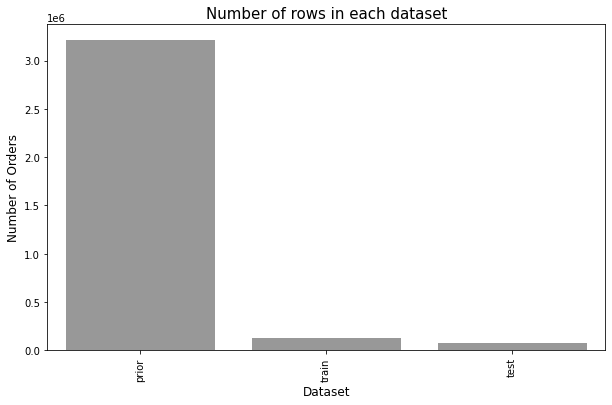

In [170]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_orders = df_orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)
print(cnt_orders.sort_values())

color = sns.color_palette()
cnt_orders = df_orders.eval_set.value_counts()

plt.figure(figsize=(10,6))
sns.barplot(cnt_orders.index, cnt_orders.values, alpha=0.8, color=color[7])
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.title('Number of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

####  2. **Validate that instacart is providing between 4 and 100 orders for each user**

Confirmed! Number of order per user: **Max=100 and Min=4**

In [171]:
df_orders['user_id'].value_counts().sort_values(ascending = False)

82420     100
154378    100
21421     100
111466    100
142304    100
         ... 
92688       4
14251       4
177120      4
166615      4
185566      4
Name: user_id, Length: 206209, dtype: int64

/Users/miguelfrutossoriano/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



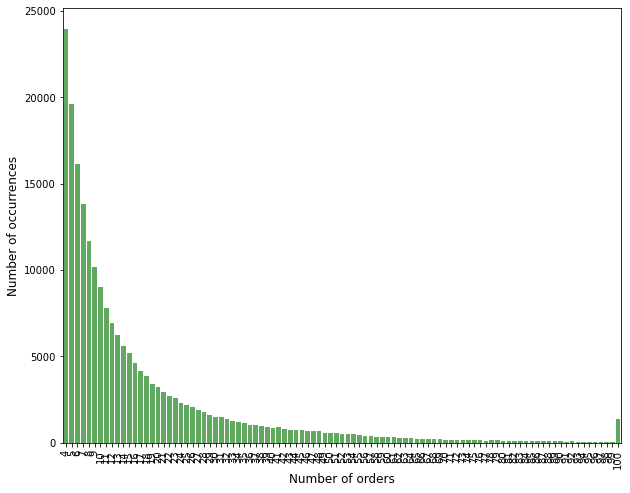

In [172]:
cnt_srs = df_orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(10,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Number of orders', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### 3. **Study the Frequency! Day of the Week and Hour with most frequency of users (iteractions)**

- The majority of the orders are made during the weekend.
- 10-11 Happy hours. Follows an apparent normal distribution.
- Mean of 11 days_since_prior_order. Finding: Weekly and Monthly Recurrency as a pattern in some users.

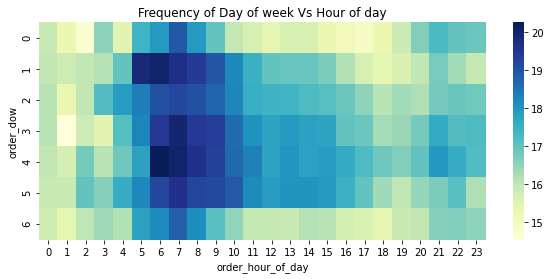

In [173]:
grouped_df = df_orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(10,4))
sns.heatmap(grouped_df,cmap="YlGnBu")
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

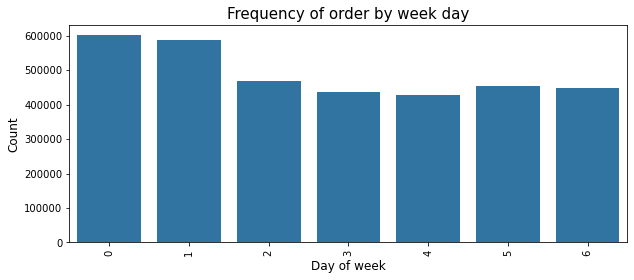

In [174]:
plt.figure(figsize=(10,4))
sns.countplot(x="order_dow", data=df_orders, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

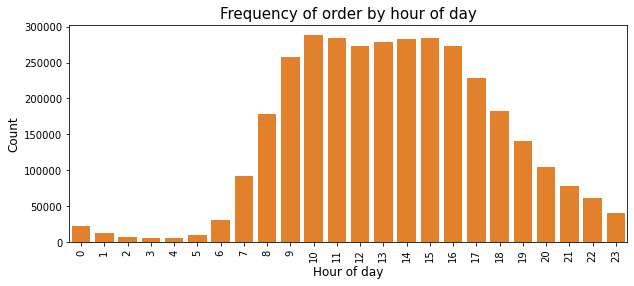

In [175]:
plt.figure(figsize=(10,4))
sns.countplot(x="order_hour_of_day", data=df_orders, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

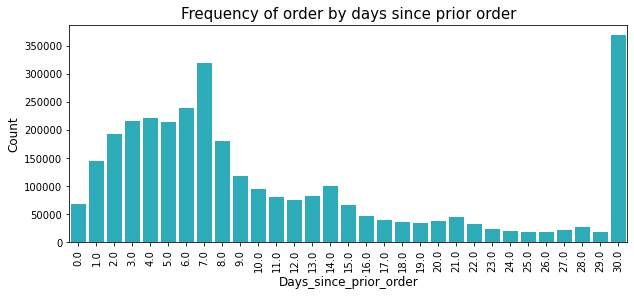

In [176]:
plt.figure(figsize=(10,4))
sns.countplot(x="days_since_prior_order", data=df_orders, color=color[9])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days_since_prior_order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by days since prior order", fontsize=15)
plt.show()

In [177]:
df_orders['days_since_prior_order'].mean()

11.114836226863012

<a id="ch5"></a>
# Chapter 5 - Prepare and structure the data to be useable by the word2vec algorithm

In [178]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    # Make everything lowercase.
    text = text.lower()
    # Clean special characters.
    text = text.replace('\W', ' ')
    #Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    #Remove symbol ®
    text = re.sub(r'®','',text)
    #Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    #remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)
    

In [179]:
#Apply clean_text
df_clean = pd.DataFrame(df_products.product_name.apply(lambda x: clean_text(x)))

In [180]:
#Checking missings
missing_values = df_clean.isnull().sum().sort_values(ascending=False)
missing_values

product_name    6
dtype: int64

In [181]:
#Change col name
df_clean = df_clean.rename(columns = {'product_name':'prod_name_new'})

In [182]:
#Comparison with the, before cleaning, product_name column
df = pd.DataFrame(pd.concat([df_products, df_clean], axis=1, join="inner"))

In [183]:
#Display the 6 products
df[df['prod_name_new'].isnull()]

,product_id,product_name,aisle_id,department_id,prod_name_new
529,530,7UP,77,7,None
4155,4156,7-Up,77,7,None
18560,18561,805,27,5,None
25333,25334,1664,27,5,None
27940,27941,All-In-1,74,17,None
38323,38324,2010,28,5,None


In [184]:
#Drop 6 products.
df = df[df['prod_name_new'].notna()]

[**Stemming and lemmatization**](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)<br>
For grammatical reasons, documents are going to use different forms of a word, such as organize, organizes, and organizing. Additionally, there are families of derivationally related words with similar meanings, such as democracy, democratic, and democratization. In many situations, it seems as if it would be useful for a search for one of these words to return documents that contain another word in the set.

The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. For instance:
- am, are, is $\Rightarrow$ be
- car, cars, car's, cars' $\Rightarrow$ car

The result of this mapping of text will be something like:
- the boy's cars are different colors $\Rightarrow$
- the boy car be differ color

However, the two words differ in their flavor. 
- **Stemming** usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. 
- **Lemmatization** usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma . 

If confronted with the token saw, stemming might return just s, whereas lemmatization would attempt to return either see or saw depending on whether the use of the token was as a verb or a noun. The two may also differ in that stemming most commonly collapses derivationally related words, whereas lemmatization commonly only collapses the different inflectional forms of a lemma. Linguistic processing for stemming or lemmatization is often done by an additional plug-in component to the indexing process, and a number of such components exist, both commercial and open-source.

In [185]:
#Transform product_name from object to string type for lemmatization
df['prod_name_new'] = df['prod_name_new'].astype('str')

In [186]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def lemmatizer(text):        
    sent = []
    Doc = nlp(text)
    for word in Doc:
        sent.append(word.lemma_)
    return " ".join(sent)

df["text_lemmatize"] =  df.apply(lambda x: lemmatizer(x['prod_name_new']), axis=1)

In [187]:
df.head()

,product_id,product_name,aisle_id,department_id,prod_name_new,text_lemmatize
0,1,Chocolate Sandwich Cookies,61,19,chocolate sandwich cookies,chocolate sandwich cookie
1,2,All-Seasons Salt,104,13,allseasons salt,allseason salt
2,3,Robust Golden Unsweetened Oolong Tea,94,7,robust golden unsweetened oolong tea,robust golden unsweetene oolong tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,smart ones classic favorites mini rigatoni vod...,smart one classic favorite mini rigatoni vodka...
4,5,Green Chile Anytime Sauce,5,13,green chile anytime sauce,green chile anytime sauce


In [188]:
#Remove -PRON- type as it is not adding value but complexity into the model
df['text_lemmatize_clean'] = df['text_lemmatize'].str.replace('-PRON-', '')

In [189]:
# Split products into terms: Tokenize.
df['text_lemmatize_tokenize'] = df['text_lemmatize'].str.split()

In [190]:
df.head()

,product_id,product_name,aisle_id,department_id,prod_name_new,text_lemmatize,text_lemmatize_clean,text_lemmatize_tokenize
0,1,Chocolate Sandwich Cookies,61,19,chocolate sandwich cookies,chocolate sandwich cookie,chocolate sandwich cookie,"[chocolate, sandwich, cookie]"
1,2,All-Seasons Salt,104,13,allseasons salt,allseason salt,allseason salt,"[allseason, salt]"
2,3,Robust Golden Unsweetened Oolong Tea,94,7,robust golden unsweetened oolong tea,robust golden unsweetene oolong tea,robust golden unsweetene oolong tea,"[robust, golden, unsweetene, oolong, tea]"
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,smart ones classic favorites mini rigatoni vod...,smart one classic favorite mini rigatoni vodka...,smart one classic favorite mini rigatoni vodka...,"[smart, one, classic, favorite, mini, rigatoni..."
4,5,Green Chile Anytime Sauce,5,13,green chile anytime sauce,green chile anytime sauce,green chile anytime sauce,"[green, chile, anytime, sauce]"


In [191]:
#Get products & unique words
products = [row.split() for row in df['text_lemmatize_clean']]
word_freq = defaultdict(int)
for word in products:
    for i in word:
        word_freq[i] += 1
print(f"We have {len(products)} products")
print(f"We have {len(word_freq)} unique words")

We have 49682 products
We have 10195 unique words


In [192]:
#Have a look top 10 most frequent words
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['organic',
 'chocolate',
 'cheese',
 'free',
 'chicken',
 'bar',
 'original',
 'sauce',
 'cream',
 'mix']

In [193]:
#Make it a sorted dictionary of the top10
top_10 = dict(Counter(word_freq).most_common(10))
top_10

{'organic': 5055,
 'chocolate': 2459,
 'cheese': 2104,
 'free': 1875,
 'chicken': 1529,
 'bar': 1499,
 'original': 1455,
 'sauce': 1306,
 'cream': 1288,
 'mix': 1179}

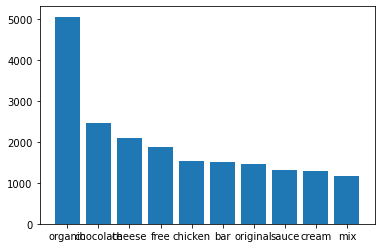

In [194]:
#Plot it
names = list(top_10.keys())
values = list(top_10.values())

plt.bar(range(len(top_10)),values,tick_label=names)
plt.show()

<a id="ch6"></a>
# Chapter 6 - Generate a vector model

### What if we take the average between vectors?

<img src="https://i.stack.imgur.com/y41eK.png">

In the picture above, in the first example with 3 objects, you can see that center of mass much closer to the two objects that form small cluster. The same idea with word vectors. Each word is an object and sentence (or tweet) is just a set of these objects. If many vectors from the tweet close to each other in space than the overall average will be close to this cluster and would be a good representation of the tweet.

One remark is that taking average can be the same as just summing vectors, because in most cases you will use cosine similarity for finding close vectors. And with cosine similarity, dividing vector by 𝑛 is the same as multiplying it by 1/𝑛 which is a scalar and scale of the vector doesn't matter if you measure distance using angles.
<img src= './user_id.png'>

### PRE-MODEL
#### Implementing Word2vec embedding in Gensim
- `min_count`: Minimum number of occurrences of a word in the corpus to be included in the model. The higher the number, the less words we have in our corpus. Please note, the results could change if we change `min_count`. 
    - For example, if we set `min_count=100`, we will have more words to work with, some of them may be more similar to the target words; 
    - If we set `min_count=300`, some results may disappear.
- `window`: The maximum distance between the current and predicted word within a sentence.
- `size`: The dimensionality of the feature vectors.
- `workers`: I know my system is having 4 cores.
- `model.build_vocab`: Prepare the model vocabulary.
- `model.train`: Train word vectors.
- `model.init_sims()`: When we do not plan to train the model any further, we use this line of code to make the model more memory-efficient.

In [195]:
##Word2Vec is an pre-trained Embedding created by Google.


#MODEL:
#List of Lists as input to our model.
#Size of the Vector 20.
#Window 5: Gensim default window size is 5 (two words before and two words after the input word.
#Minimum number of ocurrences = 1

w2vec_model = Word2Vec(list(df['text_lemmatize_tokenize']), vector_size=20, window=5, min_count=1, workers=4)

### WORDS VECTORS

In [196]:
# Create  dictionaries to obtain word vectors

#Loop the words 
word_vec = dict()
for w in w2vec_model.wv.index_to_key:
    word_vec[w] = w2vec_model.wv[w]
    
display(list(word_vec.items())[:2])

[('organic',
  array([-0.88393325, -0.29033825,  0.64234763,  1.4713523 ,  0.35409003,
         -1.2768946 ,  0.25064555,  2.0786462 , -1.1283855 , -0.32727146,
          1.1430701 ,  0.68624264,  0.03105631, -0.02560787,  0.11943869,
         -0.09782794,  1.7590164 , -0.06270667, -0.9140032 , -2.159115  ],
        dtype=float32)),
 ('chocolate',
  array([-0.06986404,  2.5843787 ,  4.002457  ,  0.07476386,  0.57414293,
         -0.8300063 , -0.02569297,  1.5284612 , -3.2259357 , -1.6399753 ,
          1.1602815 , -2.1349385 ,  0.69436103, -2.0432806 ,  0.21421735,
          0.78282595,  3.038473  , -2.6430516 , -2.909245  , -1.5879769 ],
        dtype=float32))]

### PRODUCT VECTORS

In [197]:
# Create  dictionaries to obtain prod vectors
# Loop through each word in the product name to generate the vector.
# The vector for each product would be the average of the different words

prods_w2v = dict()
for index, row in df.iterrows():
    word_vector = list()
    #print(row['Products_mod'])
    for word in row['text_lemmatize_tokenize']:
        word_vector.append(word_vec[word])
    
    prods_w2v[row['text_lemmatize_clean']] = np.average(word_vector, axis=0)

In [198]:
display(list(prods_w2v.items())[:2])

[('chocolate sandwich cookie',
  array([-0.32436493,  1.0927025 ,  2.0798817 ,  0.0560292 ,  0.5968431 ,
         -0.42747244,  0.32384005,  0.64077866, -1.4362917 , -1.2002903 ,
          1.815772  , -1.4794506 ,  0.68431807, -2.2657835 ,  0.8154392 ,
          0.788022  ,  3.098624  , -2.5258572 , -2.2895768 , -1.8606206 ],
        dtype=float32)),
 ('allseason salt',
  array([-0.29409662,  0.5466452 ,  0.0795645 , -0.10992062, -1.0359374 ,
         -0.58176404,  0.06767157,  2.4202602 , -1.0770726 , -0.5623812 ,
          0.7196417 , -1.8887314 , -0.2423585 , -0.7078906 , -0.9062849 ,
         -0.51956284,  0.61179405, -1.2951734 , -0.24408379, -1.8659747 ],
        dtype=float32))]

In [199]:
#Including product_vector inside the dataframe
prod = pd.DataFrame(list(prods_w2v.items()),columns = ['column1','column2'])
prod = prod.rename(columns = {'column1':'text_lemmatize_clean'})
prod = prod.rename(columns = {'column2':'prod_vector'})
new = pd.merge(df, prod, on="text_lemmatize_clean")
new

,product_id,product_name,aisle_id,department_id,prod_name_new,text_lemmatize,text_lemmatize_clean,text_lemmatize_tokenize,prod_vector
0,1,Chocolate Sandwich Cookies,61,19,chocolate sandwich cookies,chocolate sandwich cookie,chocolate sandwich cookie,"[chocolate, sandwich, cookie]","[-0.32436493, 1.0927025, 2.0798817, 0.0560292,..."
1,2,All-Seasons Salt,104,13,allseasons salt,allseason salt,allseason salt,"[allseason, salt]","[-0.29409662, 0.5466452, 0.0795645, -0.1099206..."
2,3,Robust Golden Unsweetened Oolong Tea,94,7,robust golden unsweetened oolong tea,robust golden unsweetene oolong tea,robust golden unsweetene oolong tea,"[robust, golden, unsweetene, oolong, tea]","[0.3963687, -0.28916413, 1.095438, 0.50560147,..."
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,smart ones classic favorites mini rigatoni vod...,smart one classic favorite mini rigatoni vodka...,smart one classic favorite mini rigatoni vodka...,"[smart, one, classic, favorite, mini, rigatoni...","[-0.24122757, 0.30955485, 0.23189995, 0.935004..."
4,5,Green Chile Anytime Sauce,5,13,green chile anytime sauce,green chile anytime sauce,green chile anytime sauce,"[green, chile, anytime, sauce]","[0.24161938, 0.10774355, 0.15528995, 1.4336314..."
...,...,...,...,...,...,...,...,...,...
49677,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5,vodka triple distilled twist vanilla,vodka triple distil twist vanilla,vodka triple distil twist vanilla,"[vodka, triple, distil, twist, vanilla]","[-0.11795429, 0.24415383, 1.3251883, 0.4528620..."
49678,49685,En Croute Roast Hazelnut Cranberry,42,1,en croute roast hazelnut cranberry,en croute roast hazelnut cranberry,en croute roast hazelnut cranberry,"[en, croute, roast, hazelnut, cranberry]","[0.39020154, 0.67114514, 0.9432151, 0.9514961,..."
49679,49686,Artisan Baguette,112,3,artisan baguette,artisan baguette,artisan baguette,"[artisan, baguette]","[0.02540198, -0.021673888, 0.052547004, 0.2389..."
49680,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8,smartblend healthy metabolism dry cat food,smartblend healthy metabolism dry cat food,smartblend healthy metabolism dry cat food,"[smartblend, healthy, metabolism, dry, cat, food]","[-0.73920935, 0.5907052, 0.1342078, 2.4347756,..."


### BASKET VECTORS

Vectorizing the different baskets opens up an exploration on recommendation systems between **similar baskets**.

In [200]:
baskets = pd.merge(new[['product_id', 'text_lemmatize_clean']], df_order_products__prior[['order_id', 'product_id']])

In [201]:
baskets.tail()

,product_id,text_lemmatize_clean,order_id
32433061,49688,fresh foaming cleanser,3111954
32433062,49688,fresh foaming cleanser,3122003
32433063,49688,fresh foaming cleanser,3166828
32433064,49688,fresh foaming cleanser,3290206
32433065,49688,fresh foaming cleanser,3401313


In [202]:
basket_lists = baskets.groupby('order_id')['text_lemmatize_clean'].apply(list)
basket_lists_id = baskets.groupby('order_id')['product_id'].apply(list)
display(basket_lists.head())
display(basket_lists_id.head())

order_id
2    [natural stir creamy almond butter, natural sw...
3    [air chill organic boneless skinless chicken b...
4    [kelloggs nutrigrain apple cinnamon cereal, go...
5    [apricot preserve, meyer lemon, reduce fat mil...
6    [dryer sheet geranium scent, cleanse, clean da...
Name: text_lemmatize_clean, dtype: object

order_id
2    [1819, 30035, 9327, 17794, 28985, 33120, 40141...
3    [17461, 17668, 17704, 21903, 24838, 32665, 337...
4    [10054, 17616, 21351, 22598, 25146, 26434, 277...
5    [12962, 38693, 23909, 6184, 6348, 8479, 9633, ...
6                                [15873, 40462, 41897]
Name: product_id, dtype: object

In [203]:
# Obtain vector avg for each basket.
# As there are 3m baskets... this might take some time as well

baskets_w2vec = dict()
print('executing...')
i = 2
basket_lists.to_frame()
for basket in basket_lists.to_frame().reset_index().iterrows():
    basket_vector = list()
    #print(basket)
    for product in basket[1]['text_lemmatize_clean']:
        basket_vector.append(prods_w2v[product])

    baskets_w2vec[basket[1]['order_id']] = np.average(basket_vector, axis=0)
    i +=1

executing...


In [204]:
# Order_ID: Vector
list(baskets_w2vec.items())[:5]

[(2,
  array([-0.2769533 ,  0.15380491,  0.6421502 ,  0.8602274 , -0.04550407,
         -0.16704345, -0.28047588,  1.3643308 , -0.9247804 ,  0.11029533,
          0.9011812 , -0.33529443,  0.05975505, -0.514279  ,  0.60829484,
          0.30181706,  1.0472758 , -0.4517306 , -0.6118893 , -1.3149234 ],
        dtype=float32)),
 (3,
  array([-0.26962397, -0.19100119,  1.2234863 ,  1.1286722 , -0.49598607,
         -0.4705046 , -0.06467195,  1.3129292 , -0.95349663, -0.07712567,
          0.90230674, -0.0570721 ,  0.47501507, -0.58785903,  0.7908509 ,
         -0.00879903,  1.2938718 , -0.04258336, -1.080141  , -1.3538598 ],
        dtype=float32)),
 (4,
  array([-0.31102017,  0.267302  ,  1.4989909 ,  1.0023386 , -0.40432966,
         -0.7318114 , -0.03602744,  0.9742765 , -1.0935867 , -0.3841251 ,
          1.2488635 ,  0.06487168,  0.19876559, -1.075293  ,  0.8639071 ,
          0.5399445 ,  1.0948435 , -0.68671316, -1.3180416 , -1.1485069 ],
        dtype=float32)),
 (5,
  array([-0.08

In [205]:
basket_lists = basket_lists.to_frame()#.reset_index()

In [206]:
basket_lists['order_id']=basket_lists.index

In [207]:
basket_lists

,text_lemmatize_clean,order_id
order_id,,
2,"[natural stir creamy almond butter, natural sw...",2
3,[air chill organic boneless skinless chicken b...,3
4,"[kelloggs nutrigrain apple cinnamon cereal, go...",4
5,"[apricot preserve, meyer lemon, reduce fat mil...",5
6,"[dryer sheet geranium scent, cleanse, clean da...",6
...,...,...
3421079,[moisture soap],3421079
3421080,"[organic raw coconut butter, vanilla bean ice ...",3421080
3421081,"[pepper jack cheese slice, classic wheat bread...",3421081


In [208]:
# To make it easy to insert into the dataframe we're generating a 
# list that can be used directly as a column in the dataframe.
# We're going to use try catch for problematic baskets. (There shouldn't be any but to keep it clean...).

basket_vectors = list()
for basket in basket_lists.iterrows():
    try:
        basket_vectors.append(baskets_w2vec[basket[1]['order_id']])
    except:
        print(basket)
        print(basket[1]['order_id'])
        print(basket[1]['text_lemmatize_clean'])
        pass

In [209]:
basket_lists['basket_vectors'] = basket_vectors
basket_lists.tail()

,text_lemmatize_clean,order_id,basket_vectors
order_id,,,
3421079,[moisture soap],3421079,"[0.505878, -0.6205983, 2.1379967, -0.5509641, ..."
3421080,"[organic raw coconut butter, vanilla bean ice ...",3421080,"[-0.5786261, 0.16823453, 1.0278033, 0.9827159,..."
3421081,"[pepper jack cheese slice, classic wheat bread...",3421081,"[-0.069579385, 0.046374492, 0.35831076, 0.9968..."
3421082,"[strawberry, toast coconut chip original recip...",3421082,"[-0.29298264, 0.15216438, 1.5976998, 1.134286,..."
3421083,"[natural french toast stick, organic sweet sal...",3421083,"[-0.82280266, 0.007980371, 1.2914681, 1.483429..."


In [210]:
basket_vector = pd.merge(basket_lists_id.to_frame().reset_index(), basket_lists, left_on='order_id', right_index=True)
basket_vector.tail()

,order_id,order_id_x,product_id,text_lemmatize_clean,order_id_y,basket_vectors
3214851,3421079,3421079,[30136],[moisture soap],3421079,"[0.505878, -0.6205983, 2.1379967, -0.5509641, ..."
3214852,3421080,3421080,"[38061, 4932, 10667, 12935, 18811, 25122, 2784...","[organic raw coconut butter, vanilla bean ice ...",3421080,"[-0.5786261, 0.16823453, 1.0278033, 0.9827159,..."
3214853,3421081,3421081,"[3060, 12218, 12861, 20539, 32299, 35221, 38185]","[pepper jack cheese slice, classic wheat bread...",3421081,"[-0.069579385, 0.046374492, 0.35831076, 0.9968..."
3214854,3421082,3421082,"[16797, 12023, 12738, 17279, 43352, 32700, 47941]","[strawberry, toast coconut chip original recip...",3421082,"[-0.29298264, 0.15216438, 1.5976998, 1.134286,..."
3214855,3421083,3421083,"[4600, 5020, 7854, 11352, 18176, 21162, 24852,...","[natural french toast stick, organic sweet sal...",3421083,"[-0.82280266, 0.007980371, 1.2914681, 1.483429..."


### USER VECTORS

We have created vectors that relate baskets to products, products to products, word to words but we can study as well a valid  approach from the user_id in two ways. 
- By recommending products based on the **similarities** between different user_id. If we had additional information such as ratings, we could use COLLABORATIVE FILTERING with the well-known *surprise* library for recommendation engines.
- Recommending products based on the **historical demand**, as we have seen before in the EDA section, every user has made between 4-100 baskets and frequently reorder some products (one-shot ratio).

In [211]:
#Merge df_orders_products__train with products, aisles and departments
orders = df_order_products__train.merge(df_orders, how='left',on='order_id')
orders = orders.merge(df_products,how='left', on ='product_id')
orders = orders.merge(df_departments,how='left', on='department_id')
orders = orders.merge(df_aisles,how='left', on='aisle_id')

In [212]:
users = pd.merge(new[['product_id', 'text_lemmatize_clean']], orders[['user_id', 'product_id']])

In [213]:
users.tail()

,product_id,text_lemmatize_clean,user_id
1384537,49687,smartblend healthy metabolism dry cat food,137573
1384538,49688,fresh foaming cleanser,159099
1384539,49688,fresh foaming cleanser,40460
1384540,49688,fresh foaming cleanser,187233
1384541,49688,fresh foaming cleanser,40384


In [214]:
users_lists = users.groupby('user_id')['text_lemmatize_clean'].apply(list)
users_lists_id = users.groupby('user_id')['product_id'].apply(list)
display(users_lists.tail())
display(users_lists_id.tail())

user_id
206199    [organic peel cooked beet, original fresh stac...
206200    [organic navel orange, basil, organic strawber...
206203    [protein bar lemon cream pie, original whole f...
206205    [mango chunk, classic guacamole, organic straw...
206209    [diet pepsi pack, calcium enrich lactose free ...
Name: text_lemmatize_clean, dtype: object

user_id
206199    [1468, 6128, 6701, 7103, 7702, 8898, 10333, 12...
206200    [8174, 8955, 21137, 13176, 15592, 21709, 22312...
206203    [2482, 3765, 3957, 31915, 13176, 14050, 15693,...
206205    [1158, 10181, 21137, 16174, 17600, 22035, 2477...
206209    [6846, 9405, 15655, 24852, 37966, 39216, 40603...
Name: product_id, dtype: object

In [215]:
# Obtain vector avg for each user.
# There are around 200k users

users_w2vec = dict()
print('executing...')
i = 2
users_lists.to_frame()
for users in users_lists.to_frame().reset_index().iterrows():
    users_vector = list()
    #print(users)
    for product in users[1]['text_lemmatize_clean']:
        users_vector.append(prods_w2v[product])
        #print(users_vector)

    users_w2vec[users[1]['user_id']] = np.average(users_vector, axis=0)
    i +=1

executing...


In [216]:
# Order_ID: Vector
list(users_w2vec.items())[1:]

[(2,
  array([-0.27285066,  0.22302033,  0.5465213 ,  0.98431545, -0.21919817,
         -0.16468857, -0.11125461,  1.1365311 , -0.572564  ,  0.41414055,
          1.0499822 , -0.25027505,  0.39916393, -0.49004358,  0.6632696 ,
          0.15546376,  0.9805551 , -0.6789369 , -0.60341036, -1.5223991 ],
        dtype=float32)),
 (5,
  array([-0.4059096 , -0.30193862,  0.29312536,  1.0432572 , -0.24655734,
         -0.3049045 , -0.24160348,  1.7210422 , -0.54990566,  0.34171537,
          1.0716817 , -0.33780405,  0.55172735, -0.07687244,  0.69187456,
          0.30621153,  1.2645141 , -0.5771002 , -0.5596372 , -1.4602642 ],
        dtype=float32)),
 (7,
  array([-0.03508406,  0.19385894,  1.4146329 ,  1.0967115 , -0.5634043 ,
         -0.254935  ,  0.13735862,  0.98872036, -0.9423118 , -0.0637165 ,
          0.65418863,  0.32699996,  0.4869797 , -0.6385613 ,  0.63978374,
          0.30773795,  1.031884  , -0.16410035, -1.1450295 , -1.6413159 ],
        dtype=float32)),
 (8,
  array([-0.23

In [217]:
users_lists = users_lists.to_frame()

In [218]:
users_lists['user_id']=users_lists.index

In [219]:
users_lists

,text_lemmatize_clean,user_id
user_id,,
1,"[soda, pistachio, cinnamon toast crunch, organ...",1
2,"[organic cashew carrot ginger soup, mint chip,...",2
5,"[organic grape tomato, organic raw agave necta...",5
7,"[lean ground beef, panama peach antioxidant in...",7
8,"[organic green onion, broccoli rabe, vidalia o...",8
...,...,...
206199,"[organic peel cooked beet, original fresh stac...",206199
206200,"[organic navel orange, basil, organic strawber...",206200
206203,"[protein bar lemon cream pie, original whole f...",206203


In [220]:
# To make it easy to insert into the dataframe we're generating a 
# list that can be used directly as a column in the dataframe.
# We're going to use try catch for problematic baskets. (There shouldn't be any but to keep it clean...).

users_vectors = list()
for users in users_lists.iterrows():
    try:
        users_vectors.append(users_w2vec[users[1]['user_id']])
    except:
        print(users)
        print(users[1]['user_id'])
        print(users[1]['text_lemmatize_clean'])
        pass

In [221]:
users_lists['user_vectors'] = users_vectors
users_lists.tail()

,text_lemmatize_clean,user_id,user_vectors
user_id,,,
206199,"[organic peel cooked beet, original fresh stac...",206199,"[-0.28840333, 0.15697731, 0.8774628, 0.8762550..."
206200,"[organic navel orange, basil, organic strawber...",206200,"[-0.393654, -0.11200569, 1.1949466, 1.2216997,..."
206203,"[protein bar lemon cream pie, original whole f...",206203,"[-0.28120634, 0.015032452, 1.3239722, 0.885170..."
206205,"[mango chunk, classic guacamole, organic straw...",206205,"[-0.6285176, -0.054446213, 1.1803827, 1.369388..."
206209,"[diet pepsi pack, calcium enrich lactose free ...",206209,"[-0.3190077, 0.28268537, 1.1568336, 1.0136656,..."


In [222]:
users_vector = pd.merge(users_lists_id.to_frame().reset_index(), users_lists, left_on='user_id', right_index=True)
users_vector.tail()

,user_id,user_id_x,product_id,text_lemmatize_clean,user_id_y,user_vectors
131203,206199,206199,"[1468, 6128, 6701, 7103, 7702, 8898, 10333, 12...","[organic peel cooked beet, original fresh stac...",206199,"[-0.28840333, 0.15697731, 0.8774628, 0.8762550..."
131204,206200,206200,"[8174, 8955, 21137, 13176, 15592, 21709, 22312...","[organic navel orange, basil, organic strawber...",206200,"[-0.393654, -0.11200569, 1.1949466, 1.2216997,..."
131205,206203,206203,"[2482, 3765, 3957, 31915, 13176, 14050, 15693,...","[protein bar lemon cream pie, original whole f...",206203,"[-0.28120634, 0.015032452, 1.3239722, 0.885170..."
131206,206205,206205,"[1158, 10181, 21137, 16174, 17600, 22035, 2477...","[mango chunk, classic guacamole, organic straw...",206205,"[-0.6285176, -0.054446213, 1.1803827, 1.369388..."
131207,206209,206209,"[6846, 9405, 15655, 24852, 37966, 39216, 40603...","[diet pepsi pack, calcium enrich lactose free ...",206209,"[-0.3190077, 0.28268537, 1.1568336, 1.0136656,..."


<a id="ch7"></a>
# Chapter 7 -  Pre-model and Exploration 

### ANALYSING WORD VECTOR SIGNATURE

#### Analizing Vector = "gluten"

In [223]:
#206 PRODUCTS contain the word "bio"
vectors_confusion = (new[new['text_lemmatize_clean'].str.contains("healthy")].prod_vector)
vectors_confusion

57       [-0.54869646, 0.5125433, 0.74623346, 0.2929999...
106      [-0.5625986, 0.56562465, -0.38305616, 1.319643...
855      [-0.06839511, 0.0050719017, 0.39845902, 0.5420...
1639     [-0.6404037, 0.21763916, 1.787603, 1.3310672, ...
2112     [-0.21873553, 0.44990593, 0.4033927, 1.2633729...
                               ...                        
47768    [-0.8660406, 0.855079, 0.2058515, 3.1781514, -...
47997    [-0.6240279, 0.87180775, -0.009867187, 2.35229...
49031    [-0.31246543, 0.6717909, 0.21016693, 1.4673985...
49580    [1.0488544, 0.21318327, 0.7010001, 0.21236236,...
49680    [-0.73920935, 0.5907052, 0.1342078, 2.4347756,...
Name: prod_vector, Length: 123, dtype: object

In [224]:
#Taking the average or the 206 vectors and reducing it to one vector with the avg of the (206) others
vectors_array = list()
for i in vectors_confusion:
    vectors_array.append(np.asarray(i))
    
vectors_array = np.asarray(vectors_array)
np.average(vectors_array, axis=0)

array([-0.20178561,  0.5073491 ,  0.32740274,  1.2396892 , -0.4186293 ,
       -0.17276151, -0.31234354,  0.91733915, -0.7220105 ,  0.7956391 ,
        0.9773379 , -0.21151733,  0.25923032, -0.38319266,  1.0709686 ,
        0.29669052,  0.7061961 , -0.87179506, -0.6176656 , -1.4610817 ],
      dtype=float32)

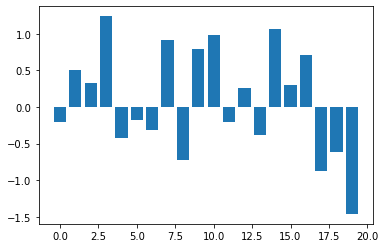

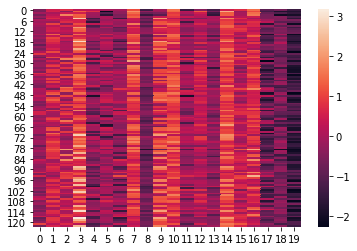

In [225]:
plt.bar(range(0, len(np.average(vectors_array, axis=0))), np.average(vectors_array, axis=0))
plt.show()
ax = sns.heatmap(vectors_array)

The signature is not so similar as other example we have seen previously (i.e. "Gluten").

<a id="ch8"></a>
# Chapter 8 -  Visualizations with t-SNE

### T-SNE

Coming from 20 vector dimensions, t-SNE opens the possibility to visulize the spectrum in 2D and 3D (dim. reduction technique). 

- In **t-SNE optimisation**, all pairs of points are repulsed from each other, but only a small number of pairs feel attractive forces.

- So if your **perplexity** is very small, then there will be fewer pairs that feel any attraction and the resulting embedding will tend to be "fluffy": repulsive forces will dominate and will inflate the whole embedding to a bubble-like round shape. On the other hand, if your perplexity is large, clusters will tend to shrink into denser structures.

    - Perplexity is the main parameter controlling the fitting of the data points into the algorithm. The recommended **range will be (5–50)**. By default is 30.
    - Perplexity should always be lesser than the number of datapoints.
    - **Low perplexity** → cares about the local structure and focuses on the closest data points.
    - **High perplexity** → cares about global structure.

- t-SNE is a tool to **visualize high-dimensional data**. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

- **t-SNE has a cost function that is not convex**, i.e. with different initializations we can get different results.

- It is highly recommended to use another dimensionality reduction method (e.g. **PCA for dense data or TruncatedSVD** for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples. For more tips see Laurens van der Maaten’s FAQ.

Since we are using Scikit-learn, we can refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to find out the default value of these parameters.
- `n_components`: Dimension of the embedded space.(int, default=2)
- `perplexity`: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results. (float, default=30.0)
- `n_iter`: Maximum number of iterations for the optimization. Should be at least 250. (int, default=1000)
- `init`: Initialization of embedding. Possible options are ‘random’, ‘pca’, and a numpy array of shape (n_samples, n_components). PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization. init='pca' will become default in 1.2. ({‘random’, ‘pca’} or ndarray of shape (n_samples, n_components), default=’random’).
- `random_state`: Determines the random number generator. Pass an int for reproducible results across multiple function calls. Note that different initializations might result in different local minima of the cost function. (int, RandomState instance or None, default=None)


### WORD VECTORS

In [226]:
df_wordvectors = pd.DataFrame()
df_wordvectors['words'] =  word_vec.keys()
df_wordvectors['vectors'] =  word_vec.values()
df_wordvectors.head(1)

,words,vectors
0,organic,"(-0.88393325, -0.29033825, 0.64234763, 1.47135..."


In [227]:
def tsne_plot(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)
    # Train the TSNE MODEL
    tsne_model = TSNE(perplexity=40,
                      n_components=2,
                      init='pca',
                      n_iter=2500,
                      random_state=23)
    # Fit the model
    new_values = tsne_model.fit_transform(tokens)
    
    # Create a new dataframe with the results
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    #plot it  
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [228]:
w2vec_model_v1 = Word2Vec(min_count=300, window=5, workers=4)

w2vec_model_v1.build_vocab(products)
w2vec_model_v1.train(products, total_examples=w2vec_model_v1.corpus_count, epochs=5)
w2vec_model_v1.init_sims(replace=True)

/var/folders/7g/_jsw2zx10fq66kvg3f8rms_h0000gn/T/ipykernel_93894/2582480971.py:5: DeprecationWarning:

Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).



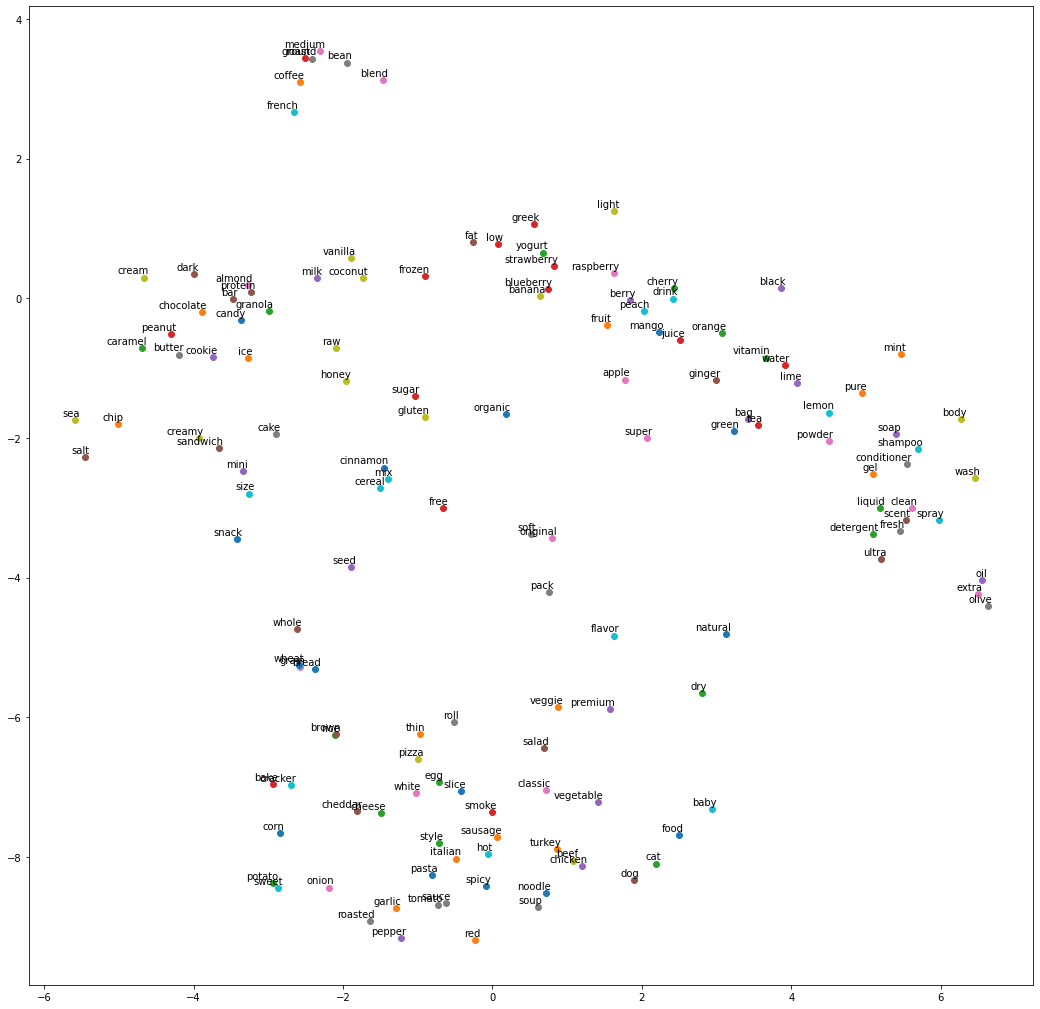

In [229]:
#Out of the 10197 unique words, plotting in 2D the ones that have been repeated at least 300 times.
# w2vec_model_v1 --> min_count=300
tsne_plot(w2vec_model_v1)

#### Studing Perplexity Variance - Generate a GIF
**Note**: The following will involve one t-SNE calculation per GIF frame. If you're running this on Colab (which only has 2 CPU cores), you can start this and walk away for at least an hour.

In [230]:
#Taking the top 10 mentioned words.
words_10 = sorted(word_freq, key=word_freq.get, reverse=True)[:10]

In [231]:
embedding_clusters_gif = []
word_clusters_gif = []
for word in words_10:
    embeddings = []
    words = []
    for similar_word, _ in w2vec_model_v1.wv.most_similar(word, topn=200):
        words.append(similar_word)
        embeddings.append(w2vec_model_v1.wv[similar_word])
    embedding_clusters_gif.append(embeddings)
    word_clusters_gif.append(words)

embedding_clusters_gif = np.array(embedding_clusters_gif)
n, m, k = embedding_clusters_gif.shape

In [232]:
# Generate a bunch of frames for the GIF

# This GIF-generating code does not play well with interactive plots
%matplotlib inline 

def tsne_plot_similar_words_png(title, embedding_clusters, a, filename):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(embedding_clusters)))
    i = 1
    for embeddings, color in zip(embedding_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color], alpha=a)
        plt.text(x.mean(), y.mean(), str(i), color='white', weight='bold', fontsize=13, path_effects=[PathEffects.withStroke(linewidth=3,
                                                                          foreground="black", alpha=0.7)])
        i += 1
    plt.title(title)
    plt.grid(True)
    plt.xlim(-200, 200)
    plt.ylim(-200, 200)
    plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.close()

dirpath = tempfile.mkdtemp()

# loop over perplexity values
images = []
for i in range(1, 31):
    print(f"Generating frame {i}/30")
    fname = os.path.join(dirpath, str(i) + '.png')
    tsne_model_en_2d_gif = TSNE(perplexity=i, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d_gif = np.array(tsne_model_en_2d_gif.fit_transform(embedding_clusters_gif.reshape(n * m, k))).reshape(n, m, 2)
    tsne_plot_similar_words_png('Vizualizing similar words using t-SNE (perplexity={})'.format(i), embeddings_en_2d_gif, 0.6, fname)
    images.append(imageio.imread(fname))
imageio.mimsave("tsne_perplexity.gif", images, duration = 0.5)
shutil.rmtree(dirpath)

Generating frame 1/30
Generating frame 2/30
Generating frame 3/30
Generating frame 4/30
Generating frame 5/30
Generating frame 6/30
Generating frame 7/30
Generating frame 8/30
Generating frame 9/30
Generating frame 10/30
Generating frame 11/30
Generating frame 12/30
Generating frame 13/30
Generating frame 14/30
Generating frame 15/30
Generating frame 16/30
Generating frame 17/30
Generating frame 18/30
Generating frame 19/30
Generating frame 20/30
Generating frame 21/30
Generating frame 22/30
Generating frame 23/30
Generating frame 24/30
Generating frame 25/30
Generating frame 26/30
Generating frame 27/30
Generating frame 28/30
Generating frame 29/30
Generating frame 30/30


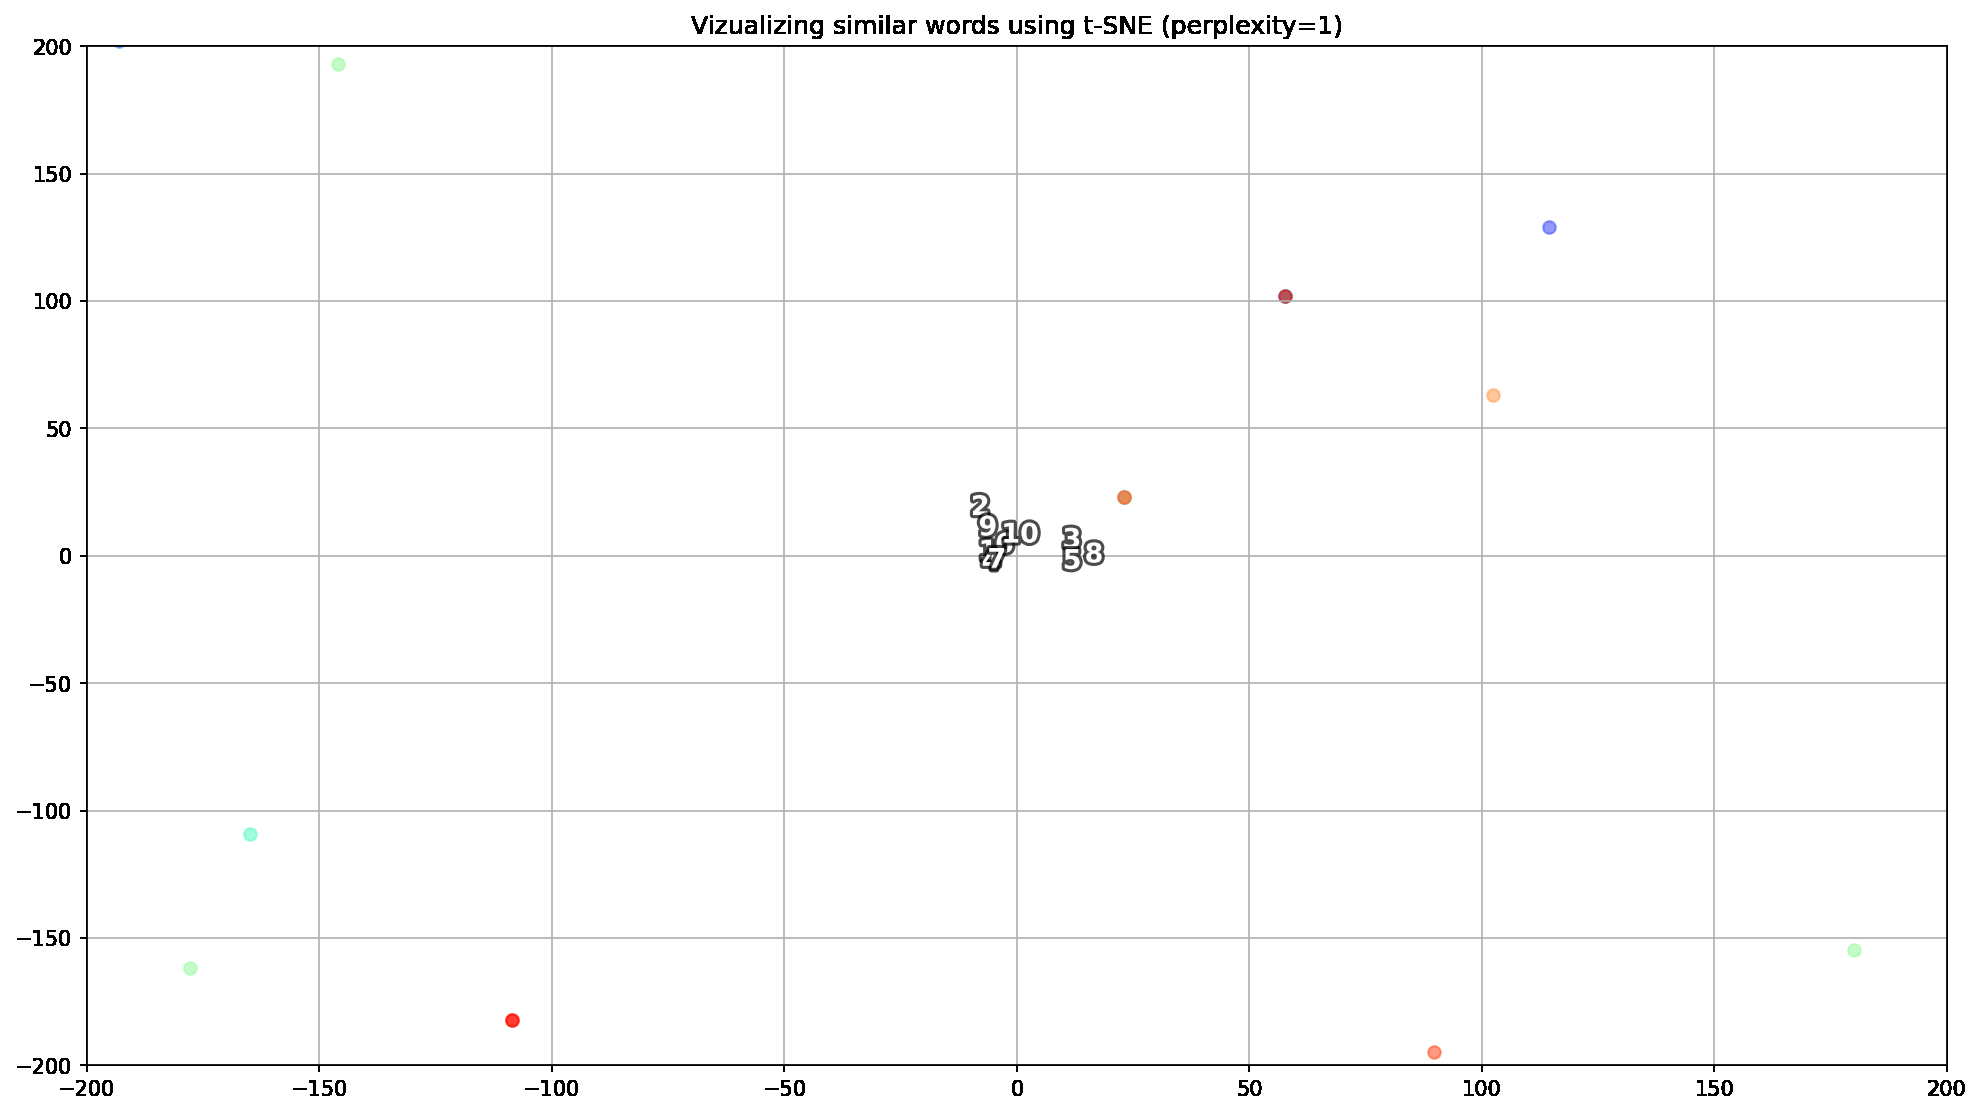

In [233]:
# Display the GIF
from IPython.display import Image
Image(open('tsne_perplexity.gif','rb').read())

### PRODUCT VECTORS

In [234]:
## We want to recover also the texts to understand what's going on with products

#List a sample of 3000 prod_vectors
w2vec_tsne = list(new.sample(n=3000, random_state=1)['prod_vector'])
#List a sample of 3000 prod_names
product_names = list(new.sample(n=3000, random_state=1)['text_lemmatize_clean'])
#List a sample of 3000 dept_id
colors = list(new.sample(n=3000, random_state=1)['department_id'])

In [235]:
# Train the TSNE MODEL
tsne_model = TSNE(perplexity=30, 
                  n_components=2,
                  init='pca',
                  n_iter=3500,
                  random_state=23)
#Fit the model
tsne_results = tsne_model.fit_transform(w2vec_tsne)

#Creating a dataframe with the results
df_tsne_data = pd.DataFrame()

df_tsne_data['tsne-2d-one'] = tsne_results[:,0]
df_tsne_data['tsne-2d-two'] = tsne_results[:,1]
df_tsne_data['product_names'] = product_names
df_tsne_data['color'] = colors

In [ ]:
fig = px.scatter(df_tsne_data,
                 x="tsne-2d-one", y="tsne-2d-two",
                 hover_data=['product_names'],
                 title='Products',
                 width=1000, height=800)
fig.show()

In [ ]:
fig = px.scatter(df_tsne_data,
                 x="tsne-2d-one", y="tsne-2d-two",
                 color="color",
                 hover_data=['product_names'],
                 title='Products',
                 width=1000, height=800)
fig.show()

In [238]:
# Train the TSNE MODEL
tsne_model = TSNE(perplexity=30,
                  n_components=3,
                  init='pca',
                  n_iter=3500,
                  random_state=23)

#Fit the model
tsne_results = tsne_model.fit_transform(w2vec_tsne)

#Creating a dataframe with the results
df_tsne_data = pd.DataFrame()

df_tsne_data['tsne-3d-one'] = tsne_results[:,0]
df_tsne_data['tsne-3d-two'] = tsne_results[:,1]
df_tsne_data['tsne-3d-three'] = tsne_results[:,2]
df_tsne_data['product_names'] = product_names
df_tsne_data['color'] = colors

In [239]:
df_tsne_data['size'] = 0.2

In [ ]:
fig = px.scatter_3d(df_tsne_data,
                    x="tsne-3d-one", y="tsne-3d-two", z="tsne-3d-three",
                    color="color",
                    hover_data=['product_names'],
                    title='Products',
                    width=1000, height=800,
                    size='size')
fig.show()

### BASKET VECTORS

In [241]:
# We want to recover also the texts to understand what's going on. 
w2vec_tsne = list(basket_vector.sample(n=3000, random_state=1)['basket_vectors'])
product_names = list(basket_vector.sample(n=3000, random_state=1)['text_lemmatize_clean'])

In [242]:
# Train the TSNE MODEL
tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=23)
tsne_results = tsne_model.fit_transform(w2vec_tsne)

df_tsne_data = pd.DataFrame()

df_tsne_data['tsne-2d-one'] = tsne_results[:,0]
df_tsne_data['tsne-2d-two'] = tsne_results[:,1]
df_tsne_data['text_lemmatize_clean'] = product_names
df_tsne_data['color'] = 1

In [ ]:
fig = px.scatter(df_tsne_data,
                 x="tsne-2d-one", y="tsne-2d-two",
                 color="color",
                 hover_data=['text_lemmatize_clean'],
                 title='Baskets',
                 width=1000, height=800,
                 marginal_x="histogram", marginal_y="histogram")
fig.show()

In [244]:
# Train the TSNE MODEL
tsne_model = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=23)
tsne_results = tsne_model.fit_transform(w2vec_tsne)

df_tsne_data = pd.DataFrame()

df_tsne_data['tsne-3d-one'] = tsne_results[:,0]
df_tsne_data['tsne-3d-two'] = tsne_results[:,1]
df_tsne_data['tsne-3d-three'] = tsne_results[:,2]
df_tsne_data['text_lemmatize_clean'] = product_names
df_tsne_data['color'] = 1

In [ ]:
fig = px.scatter_3d(df_tsne_data,
                    x="tsne-3d-one", y="tsne-3d-two", z="tsne-3d-three",
                    color="color", hover_data=['text_lemmatize_clean'],
                    title='Baskets',
                    width=1000, height=800)
fig.show()

<a id="ch9"></a>
# Chapter 9 - Use a spatial distance model like an Annoy model

One of the most prominent solutions out there is `Annoy`, which uses trees (more accurately forests) to enable Spotify’ music recommendations. Since there is a [comprehensive explanation](https://erikbern.com/2015/10/01/nearest-neighbors-and-vector-models-part-2-how-to-search-in-high-dimensional-spaces.html) I will only provide here the intuition behind it, how it should be used, the pros and the cons.
In Annoy, in order to construct the index we create a forest (aka many trees) Each tree is constructed in the following way, we pick two points at random and split the space into two by their hyperplane, we keep splitting into the subspaces recursively until the points associated with a node is small enough.

### Distance Measures

Knowing when to use which distance measure can help you go from a poor classifier to an accurate model.Many algorithms, whether supervised or unsupervised, make use of distance measures. These measures, such as euclidean distance or cosine similarity, can often be found in algorithms such as k-NN, UMAP, HDBSCAN, etc.

<table><tr>
<td> <img src="https://erikbern.com/assets/2015/09/tree-full-K-1024x793.png"  width=300, height=200 align="centre" /> </td>
<td> <img src="https://erikbern.com/assets/2015/09/tree-full-K-graphviz1-1024x404.png"  width=300, height=200 align="centre"/> </td>
<td> <img src="https://miro.medium.com/max/1400/1*FTVRr_Wqz-3_k6Mk6G4kew.png"  width=300, height=200 align="centre"/> </td>
</tr></table>

### Commands we can use annoy for. 
-  `a.get_nns_by_item`(i, n, search_k=-1, include_distances=False) returns the n closest items. During the query it will inspect up to search_k nodes which defaults to n_trees * n if not provided. search_k gives you a run-time tradeoff between better accuracy and speed. If you set include_distances to True, it will return a 2 element tuple with two lists in it: the second one containing all corresponding distances.
- `a.get_nns_by_vector`(v, n, search_k=-1, include_distances=False) same but query by vector v. 
- `a.get_item_vector`(i) returns the vector for item i that was previously added.
- `a.get_distance`(i, j) returns the distance between items i and j. NOTE: this used to return the squared distance, but has been changed as of Aug 2016.
- `a.get_n_items`() returns the number of items in the index.
- `a.get_n_trees`() returns the number of trees in the index.
- `a.on_disk_build`(fn) prepares annoy to build the index in the specified file instead of RAM (execute before adding items, no need to save after build)

In [246]:
new.tail()

,product_id,product_name,aisle_id,department_id,prod_name_new,text_lemmatize,text_lemmatize_clean,text_lemmatize_tokenize,prod_vector
49677,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5,vodka triple distilled twist vanilla,vodka triple distil twist vanilla,vodka triple distil twist vanilla,"[vodka, triple, distil, twist, vanilla]","[-0.11795429, 0.24415383, 1.3251883, 0.4528620..."
49678,49685,En Croute Roast Hazelnut Cranberry,42,1,en croute roast hazelnut cranberry,en croute roast hazelnut cranberry,en croute roast hazelnut cranberry,"[en, croute, roast, hazelnut, cranberry]","[0.39020154, 0.67114514, 0.9432151, 0.9514961,..."
49679,49686,Artisan Baguette,112,3,artisan baguette,artisan baguette,artisan baguette,"[artisan, baguette]","[0.02540198, -0.021673888, 0.052547004, 0.2389..."
49680,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8,smartblend healthy metabolism dry cat food,smartblend healthy metabolism dry cat food,smartblend healthy metabolism dry cat food,"[smartblend, healthy, metabolism, dry, cat, food]","[-0.73920935, 0.5907052, 0.1342078, 2.4347756,..."
49681,49688,Fresh Foaming Cleanser,73,11,fresh foaming cleanser,fresh foaming cleanser,fresh foaming cleanser,"[fresh, foaming, cleanser]","[0.82862407, -0.19231458, 0.47227266, 0.277257..."


In [247]:
w2vec_model_v1 = Word2Vec(min_count=300, window=5, workers=4)

w2vec_model_v1.build_vocab(products)
w2vec_model_v1.train(products, total_examples=w2vec_model_v1.corpus_count, epochs=5)
w2vec_model_v1.init_sims(replace=True)

/var/folders/7g/_jsw2zx10fq66kvg3f8rms_h0000gn/T/ipykernel_93894/2582480971.py:5: DeprecationWarning:

Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).



### WORD SIMILARITY - Word TO Word

In [248]:
#Find the most similar words for "banana"
w2vec_model_v1.wv.most_similar(positive=['milk'])

[('frozen', 0.9499822854995728),
 ('vanilla', 0.9363572597503662),
 ('almond', 0.9054585099220276),
 ('granola', 0.9038457274436951),
 ('protein', 0.8974166512489319),
 ('bar', 0.8893567323684692),
 ('candy', 0.8727606534957886),
 ('coconut', 0.8570001125335693),
 ('strawberry', 0.8484439849853516),
 ('chocolate', 0.8475494384765625)]

In [249]:
#How similar are these two words "cheese" and "chocolate"?
w2vec_model_v1.wv.similarity('cheese', 'chocolate')

0.22042581

### PRODUCT SIMILARITY - Product TO Product

#### MANHATTAN DISTANCE

In [250]:
f = 20
p = AnnoyIndex(f, metric='manhattan')  # Length of item vector that will be indexed
for index, row in new.iterrows():
    try:
        p.add_item(row['product_id'], row['prod_vector'])
    except:
        print(row['product_id'], row['vectors'])

p.build(10) # 10 trees

True

In [251]:
print(new.iloc[0]['product_name'], new.iloc[0]['prod_vector'])
similar_products = p.get_nns_by_vector(new.iloc[0]['prod_vector'], 10, include_distances=False)
display(similar_products)
list(df_products[df_products.product_id.isin(similar_products)]['product_name'])

Chocolate Sandwich Cookies [-0.32436493  1.0927025   2.0798817   0.0560292   0.5968431  -0.42747244
  0.32384005  0.64077866 -1.4362917  -1.2002903   1.815772   -1.4794506
  0.68431807 -2.2657835   0.8154392   0.788022    3.098624   -2.5258572
 -2.2895768  -1.8606206 ]


[1, 23932, 1547, 12481, 10477, 31936, 32011, 3417, 16143, 16613]

['Chocolate Sandwich Cookies',
 'Cookie Bites Chocolate Chip Cookies',
 'Chocolate Creme Cookies',
 'Caramel Chocolate Sandwich',
 'Oreo Chocolate Sandwich Cookies',
 'Chocolate Chunk Cookies',
 'Chocolate Chunk Cookie',
 'Chocolate Creme Sandwich Cookies',
 'Chocolate Chip Cookie Sandwich',
 'Mini Crunch Chocolate Chip Cookies']

#### DOT DISTANCE

In [252]:
f = 20
p = AnnoyIndex(f, metric='dot')  # Length of item vector that will be indexed
for index, row in new.iterrows():
    try:
        p.add_item(row['product_id'], row['prod_vector'])
    except:
        print(row['product_id'], row['vectors'])

p.build(10) # 10 trees

True

In [253]:
print(new.iloc[0]['product_name'], new.iloc[0]['prod_vector'])
similar_products = p.get_nns_by_vector(new.iloc[0]['prod_vector'], 10, include_distances=False)
display(similar_products)
list(df_products[df_products.product_id.isin(similar_products)]['product_name'])

Chocolate Sandwich Cookies [-0.32436493  1.0927025   2.0798817   0.0560292   0.5968431  -0.42747244
  0.32384005  0.64077866 -1.4362917  -1.2002903   1.815772   -1.4794506
  0.68431807 -2.2657835   0.8154392   0.788022    3.098624   -2.5258572
 -2.2895768  -1.8606206 ]


[3807, 40018, 37810, 25625, 29324, 48223, 2423, 17226, 48283, 36850]

['Milk Chocolate Mousse Supreme Instant Mix',
 'Chocolate Peanut Butter Non Dairy Frozen Dessert',
 'Seasonal Ice Cream',
 'Nonfat Yogurt',
 'Oreo Triple Double Chocolate Sandwich Cookies',
 'Carrot Yogurt',
 '99% Dark Chocolate Critters',
 'Protein Peanut Butter Cups',
 'Peanut Oil',
 'Premium  Vanilla Mochi Ice Cream']

#### ANGULAR DISTANCE

In [254]:
f = 20
p = AnnoyIndex(f, metric='angular')  # Length of item vector that will be indexed
for index, row in new.iterrows():
    try:
        p.add_item(row['product_id'], row['prod_vector'])
    except:
        print(row['product_id'], row['vectors'])

p.build(10) # 10 trees

True

In [255]:
print(new.iloc[0]['product_name'], new.iloc[0]['prod_vector'])
similar_products = p.get_nns_by_vector(new.iloc[0]['prod_vector'], 10, include_distances=False)
display(similar_products)
list(df_products[df_products.product_id.isin(similar_products)]['product_name'])

Chocolate Sandwich Cookies [-0.32436493  1.0927025   2.0798817   0.0560292   0.5968431  -0.42747244
  0.32384005  0.64077866 -1.4362917  -1.2002903   1.815772   -1.4794506
  0.68431807 -2.2657835   0.8154392   0.788022    3.098624   -2.5258572
 -2.2895768  -1.8606206 ]


[1, 12481, 23932, 25637, 27154, 34806, 41793, 4770, 31857, 33622]

['Chocolate Sandwich Cookies',
 'Nantucket Mini Chocolate Chunk Cookies',
 'Oreo Chocolate Sandwich Cookies',
 'Chocolate Creme Sandwich Cookies',
 'Birthday Cake Chocolate Sandwich Cookies',
 'Ultimates Chocolate Pecan Deluxe Cookie Dough',
 'Snicker Doodle Chocolate Enrobed Cookie Dough',
 'Chocolate Chunk Cookie Dough',
 'Oreo Chocolate White Fudge Covered Sandwich Cookies',
 'Mini Chocolate Chunk Cookies']

### BASKET SIMILARITY - Basket TO Basket

#### ANGULAR DISTANCE

In [256]:
f = 20
b = AnnoyIndex(f, metric='angular')  # Length of item vector that will be indexed
for index, row in basket_vector.iterrows():
    b.add_item(row['order_id'], row['basket_vectors'])

b.build(10) # 10 trees

True

In [257]:
similar_baskets = b.get_nns_by_item(2, 2, include_distances=False)
display(similar_baskets)
list(basket_vector[basket_vector.order_id.isin(similar_baskets)]['text_lemmatize_clean'])

[2, 1017834]

[['natural stir creamy almond butter',
  'natural sweetener',
  'garlic powder',
  'carrot',
  'michigan organic kale',
  'organic egg white',
  'original unflavored gelatine mix',
  'classic blend cole slaw',
  'coconut butter'],
 ['boneless skinless chicken thigh',
  'butter',
  'boneless skinless chicken breast',
  'organic avocado',
  'bag organic banana',
  'mango soft serve fruit pop',
  'organic shred carrot',
  'pork chorizo',
  'organic cilantro',
  'mojo chocolate almond coconut bar',
  'sea salt roast seaweed',
  'organic apple slice']]

### PRODUCT & BASKET SIMILARITY - Basket TO Product

In [258]:
# The user adds these products to his basket:
lista_vectors = list()
lista_vectors.append(prods_w2v['organic bread whole grain'])

In [259]:
# The vector changes as the user adds these products to the basket. 
v = np.average(lista_vectors, axis=0)
print(v)

[-0.69102347  0.35416186 -0.2923581   1.4637306   1.001303   -2.4523358
 -0.220068    2.3588274  -0.44170713 -0.42379925  1.4909958   0.40172398
  1.2381331  -0.5711547   2.1027918  -0.29512298  1.4158578  -1.1451906
 -1.8655105  -2.0340667 ]


In [260]:
similar_baskets = b.get_nns_by_vector(v, 2, search_k=-1, include_distances=False)
display(similar_baskets)

[337494, 956943]

In [261]:
for item in similar_baskets:
    for p in basket_lists[basket_lists.order_id == item]['text_lemmatize_clean']:
        display(item)

337494

956943

In [262]:
# If we continue adding products the vectors changes
lista_vectors = list()
lista_vectors.append(prods_w2v['organic tomato basil pasta sauce'])
lista_vectors.append(prods_w2v['vanilla bean frozen yogurt'])
lista_vectors.append(prods_w2v['original unflavored gelatine mix'])

# The vector changes as the user adds these products to the basket. 
v = np.average(lista_vectors, axis=0)
print(v)

similar_baskets = b.get_nns_by_vector(v, 2, search_k=-1, include_distances=False)
display(similar_baskets)

for p in similar_baskets:
    for p in basket_lists[basket_lists.order_id == p]['text_lemmatize_clean']:
        display(p)

[-0.2889348   0.33214366  0.83219546  1.3765383   0.05213439  0.0721099
 -0.21322955  1.7752914  -0.67315596  0.29854342  1.315588    0.0711017
  0.89813685 -0.6600688   0.49026725 -0.38154063  1.5858024  -0.5956164
 -1.0396556  -1.8274952 ]


[2830270, 1670184]

['vanilla almond breeze almond milk',
 'reduce fat milk',
 'red mild enchilada sauce',
 'lasagna florentine savory italian recipe',
 'red raspberry',
 'honeycrisp apple',
 'red chile enchilada sauce',
 'original whip cream',
 'carb balance flour tortilla',
 'santa fe rice bean',
 'low sodium black bean']

['organic reduce fat milk',
 'traditional plain greek yogurt',
 'organic sunday bacon',
 'organic russet potato',
 'organic fat free refrie pinto bean',
 'tomato sauce',
 'tahitian vanilla bean gelato',
 'organic small curd cottage cheese',
 'organic vegetarian baked bean',
 'vanilla cupcake']

In [ ]:
# Train the TSNE MODEL

basket_sample = basket_vector.sample(n=3000, random_state=1)
basket_sample['colors'] = '0'
basket_sample['size'] = 1
basket_vectors = list(basket_sample['basket_vectors'])
product_names = list(basket_sample['text_lemmatize_clean'])
colors = list(basket_sample['colors'])
size = list(basket_sample['size'])

basket_vectors.append(v)
product_names.append(lista_vectors)
colors.append(1)
size.append(10)

tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=23)
tsne_results = tsne_model.fit_transform(basket_vectors)

df_tsne_data = pd.DataFrame()

df_tsne_data['tsne-2d-one'] = tsne_results[:,0]
df_tsne_data['tsne-2d-two'] = tsne_results[:,1]
df_tsne_data['text_lemmatize_clean'] = product_names
df_tsne_data['color'] = colors
df_tsne_data['size'] = size

fig = px.scatter(df_tsne_data, x="tsne-2d-one", y="tsne-2d-two", color="color", hover_data=['text_lemmatize_clean'], title='Baskets', size='size', width=1000, height=800, marginal_x="histogram", marginal_y="histogram")
fig.show()

### USER SIMILARITY - User TO User

In [264]:
#Merge df_orders_products__train with products, aisles and departments
orders = df_order_products__train.merge(df_products,how='left', on ='product_id')
orders = orders.merge(df_departments,how='left', on='department_id')
orders = orders.merge(df_aisles,how='left', on='aisle_id')

In [265]:
#reordered col. == 1 refers to a user that has purchased at least 2 times this item
reorders = orders[orders['reordered'] == 1]
reorders['product_id'] = reorders['product_id'].astype('int64')

/var/folders/7g/_jsw2zx10fq66kvg3f8rms_h0000gn/T/ipykernel_93894/3225607301.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [266]:
# get list of hi volume products (products that occurr mo' than 1 tiempo)
hivol = reorders.copy()['product_id'].value_counts().sort_values(ascending=False)\
    [reorders.copy()['product_id'].value_counts().sort_values(ascending=False) > 1].index.tolist()

In [267]:
# mask the reorders dataframe to only incluse dem hi vol prods
reorders = reorders[reorders['product_id'].isin(hivol)]

In [268]:
#filters the High demand items greater than.
reorders['hi_dem'] = (reorders.copy()['product_id'].value_counts().sort_values(ascending=False)>1)

In [269]:
hidem_ord = reorders[reorders['hi_dem'] == True]

In [270]:
user_orders = reorders.merge(orders)

In [271]:
#reorders['hi_dem']
user_orders['hi_dem'] = (user_orders.copy()['product_id'].value_counts().sort_values(ascending=False)>1)

In [272]:
hidem_ord = user_orders[user_orders['hi_dem'] == True]

In [273]:
hidem_ord = hidem_ord.merge(df_orders, how='left',on='order_id')

In [274]:
#return the total items
users = hidem_ord.groupby(['user_id','product_name']).size().sort_values(ascending=False).unstack().fillna(0)

In [275]:
#creates a similiarity by users
users_sim = pd.DataFrame(cosine_similarity(users),index=users.index,columns=users.index)

In [276]:
#when including 
def next_prod(df,num_col):
    return df[df.columns[num_col]].drop(df.columns[num_col]).sort_values(ascending=False).head(3)

In [277]:
#returns similar users to this one.
pd.DataFrame(next_prod(users_sim,3000)).T

user_id,15273,134209,91609
97097,0.57735,0.57735,0.57735


##### BUT WE WANT TO DO IT WITH VECTORS! JUST LIKE BEFORE

#### ANGULAR DISTANCE

In [278]:
f = 20
u = AnnoyIndex(f, metric='angular')  # Length of item vector that will be indexed
for index, row in users_vector.iterrows():
    u.add_item(row['user_id'], row['user_vectors'])

u.build(10) # 10 trees

True

In [279]:
similar_users = u.get_nns_by_item(2, 2, include_distances=False)
display(similar_users)
list(users_vector[users_vector.user_id.isin(similar_users)]['text_lemmatize_clean'])

[2, 192960]

[['organic cashew carrot ginger soup',
  'mint chip',
  'small hass avocado',
  'gluten free mushroom risotto bowl',
  'gluten free whole grain bread',
  'granny smith apple',
  'shell pistachio',
  'organic day fresh deodorant lavender',
  'indian paneer tikka',
  'asian pear',
  'plantain chip',
  'honeycrisp apple',
  'uncure slow cooked ham',
  'bartlett pear',
  'organic hearty split pea uncure ham soup',
  'kitchen cheese enchilada',
  'organic danjou pear',
  'organic roasted turkey breast',
  'unsweetene almondmilk',
  'banana',
  'chicken caesar salad',
  'black bean vegetable burrito',
  'vegetable lasagna',
  'chipotle beef pork realstick',
  'mexican casserole bowl',
  'organic light sodium butternut squash soup',
  'bubblegum flavor natural chewing gum',
  'pad thai',
  'dark chocolate nuts sea salt bar',
  'birthday cake light ice cream',
  'pistachio ice cream'],
 ['organic dark salt burn caramel chocolate bar',
  'organic cream chicken condense soup',
  'oh yog madagasc

### USER & PRODUCT SIMILARITY - User TO Product

In [280]:
# The user adds these products to his basket:
lista_vectors = list()
lista_vectors.append(prods_w2v['large lemon'])

In [281]:
# The vector changes as the user adds these products to the basket. 
v = np.average(lista_vectors, axis=0)
print(v)

[ 0.62103176 -0.5082004   0.68315524  0.93220913 -1.2484001  -0.23472252
  0.82836235  0.770592   -0.7410335   0.5928883   1.0160924  -0.20643178
  0.79075074  0.26823634  0.94473374  0.9128028   1.7468479  -0.23794663
 -0.46650082 -0.82297695]


In [282]:
similar_users = u.get_nns_by_vector(v, 2, search_k=-1, include_distances=False)
display(similar_users)

[8913, 9693]

In [283]:
for item in similar_users:
    for p in users_lists[users_lists.user_id == item]['text_lemmatize_clean']:
        display(item)

8913

9693

In [284]:
# If we continue adding products the vectors changes
lista_vectors = list()
lista_vectors.append(prods_w2v['organic tomato basil pasta sauce'])
lista_vectors.append(prods_w2v['vanilla bean frozen yogurt'])
lista_vectors.append(prods_w2v['original unflavored gelatine mix'])

# The vector changes as the user adds these products to the basket. 
v = np.average(lista_vectors, axis=0)
print(v)

similar_users = u.get_nns_by_vector(v, 2, search_k=-1, include_distances=False)
display(similar_users)

for p in similar_users:
    for p in users_lists[users_lists.user_id == p]['text_lemmatize_clean']:
        display(p)

[-0.2889348   0.33214366  0.83219546  1.3765383   0.05213439  0.0721099
 -0.21322955  1.7752914  -0.67315596  0.29854342  1.315588    0.0711017
  0.89813685 -0.6600688   0.49026725 -0.38154063  1.5858024  -0.5956164
 -1.0396556  -1.8274952 ]


[19717, 19743]

['plain grade fat greek yogurt',
 'lime',
 'organic balance vanilla bean milk protein shake',
 'organic refried black bean',
 'creme caramel low fat frozen yogurt',
 'medium chipotle garlic taco skillet sauce',
 'low fat minty chocolate chip organic frozen yogurt',
 'natural fresh goat cheese',
 'cucumber garlic tzatziki',
 'key lime cilantro taco skillet sauce roast tomatillo green chile',
 'organic baby rainbow carrot',
 'hint sea salt almond nut thin',
 'natural original guacamole mix',
 'organic honey hemp sprout oat granola',
 'new mexico taco skillet sauce chicken',
 'roasted turkey breast',
 'oaxacan red chile mole simmer sauce']

['organic hearty garden vegetable soup',
 'organic evaporate milk',
 'organic honey sweet whole wheat bread',
 'lowfat small curd cottage cheese',
 'lightly salt bake snap pea crisps',
 'soy free buttery spread',
 'organic grade free range large brown egg',
 'total natural greek strain yogurt honey',
 'light brown sugar',
 'vanilla non dairy frozen dessert minis',
 'lactose free reduce fat milk',
 'mighty mango juice smoothie',
 'organic light sodium lentil vegetable soup',
 'total strawberry lowfat greek strain yogurt',
 'organic low fat vegetable barley soup',
 'make organic bean rice burrito nondairy',
 'kool ranch kale chip',
 'indian dal golden lentil soup',
 'hearty minestrone vegetable soup',
 'roasted turkey breast',
 'organic apple sauce',
 'organic gluten free nondairy bean rice burrito',
 'apple apricot sauce']

<a id="ch10"></a>
<a id="ch11"></a>
# Chapter 10&11- Test using either a user or product list vector | Explore the output and validate the results qualitatively

**FINAL DECISION**: Due to the high frequency of repetition between both orders and products for the same customer. The best approach would be to go after a USER-Product strategy for those that have at least one repetition and for the new customers, use a BASKET-Product approach. Ideally, both strategies could be combined to optimize the validation of the model.